In [1]:
%matplotlib inline

import time
import datetime

import numpy as np
np.set_printoptions(suppress=True) # suppress scientific notation
  # np.set_printoptions(formatter={'float_kind': '{:0.2f}'.format}) # suppress even more scientific notation
  # https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
import numpy.random as npr
import numpy_financial as npf
import pandas as pd
import pandas_datareader as pdr
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns



---

# Data Import

In [2]:
data = pd.read_csv('temp_data/tr_eikon_eod_data.csv', index_col=0, parse_dates=True, infer_datetime_format=True).dropna()
data.info()

FileNotFoundError: [Errno 2] No such file or directory: 'temp_data/tr_eikon_eod_data.csv'

In [4]:
data[data.isnull().any(axis=1)]

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,


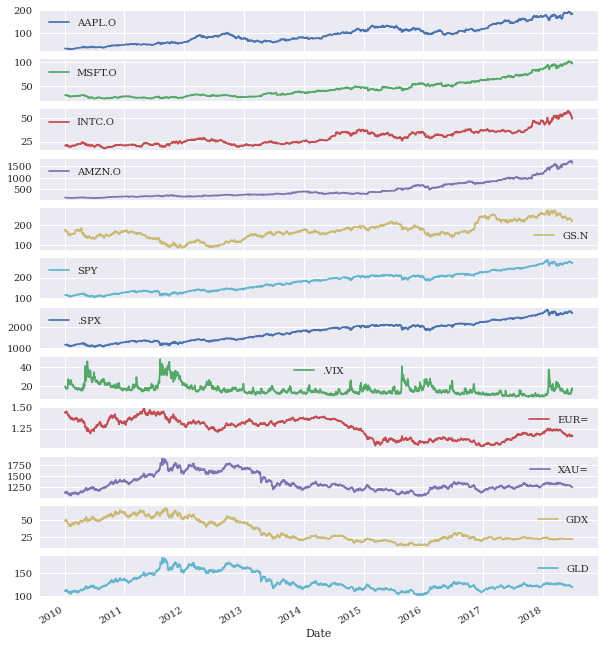

In [5]:
data.plot(figsize=(10, 12), subplots=True);

In [6]:
instruments = [
    'Apple Stock',
    'Microsoft Stock',
    'Intel Stock',
    'Amazon Stock',
    'Goldman Sachs Stock',
    'SPDR S&P 500 ETF Trust',
    'S&P 500 Index',
    'VIX Volatility Index',
    'EUR/USD Exchange Rate',
    'Gold Price',
    'VanEck Vectors Gold Miners ETF',
    'SPDR Gold Trust',
]
for ric, name in zip(data.columns, instruments):
    print(f'{ric:8s} | {name}')

AAPL.O   | Apple Stock
MSFT.O   | Microsoft Stock
INTC.O   | Intel Stock
AMZN.O   | Amazon Stock
GS.N     | Goldman Sachs Stock
SPY      | SPDR S&P 500 ETF Trust
.SPX     | S&P 500 Index
.VIX     | VIX Volatility Index
EUR=     | EUR/USD Exchange Rate
XAU=     | Gold Price
GDX      | VanEck Vectors Gold Miners ETF
GLD      | SPDR Gold Trust


---

Geometric Brownian Motion

In [7]:
def gen_paths (S0, r, sigma, T, M, I):
    ''' Generate Monte Carlo paths for geometric Brownian motion.
    
    Parameters
    ==========
    S0:    float
           initial stock/index value
    r:     float
           constant short rate
    sigma: float
           constant volatility
    T:     float
           final time horizon
    M:     int
           number of time steps/intervals
    I:     int
           number of paths to be simulated
           
    Returns
    =======
    paths: ndarray, shape (M + 1, I)
           simulated paths given the parameters
    '''
    dt       = T / M
    paths    = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std() # matching first and second moment: moment matching for variance reduction
                                                 # vectorized Euler discretization of geometric Brownian motion
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
    return paths

def print_statistics (array):
    ''' Prints selected statistics.
    
    Parameters
    ==========
    array: ndarray
           object to generate statistics on
    '''
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('min', sta[1][0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

Normality Testing

In [8]:
def normality_tests (array):
    ''' Tests for normality distribution of given data set.
    
    Parameters
    ==========
    array: ndarray
           object to generate statistics on
    '''
    print('Skew of data set  %14.3f' % scs.skew(array))
    print('Skew test p-value %14.3f' % scs.skewtest(array)[1])     # This tests whether the skew of the sample data is "normal" (i.e., has a value close enough to zero)
    print('Kurt of data set. %14.3f' % scs.kurtosis(array))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(array)[1]) # This tests whether the kurtosis of the sample data is "normal" (i.e., has a value close enough to zero)
    print('Norm test p-value %14.3f' % scs.normaltest(array)[1])   # This combines Skewness Test and Kurtosis Test to test for normality

# Subset example

In [9]:
symbols = ['SPY', 'GLD', 'AAPL.O', 'MSFT.O']
data = data[symbols]
data

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,113.33,109.80,30.572827,30.950
2010-01-05,113.63,109.70,30.625684,30.960
2010-01-06,113.71,111.51,30.138541,30.770
2010-01-07,114.19,110.82,30.082827,30.452
2010-01-08,114.57,111.37,30.282827,30.660
...,...,...,...,...
2018-06-25,271.00,119.89,182.170000,98.390
2018-06-26,271.60,119.26,184.430000,99.080
2018-06-27,269.35,118.58,184.160000,97.540


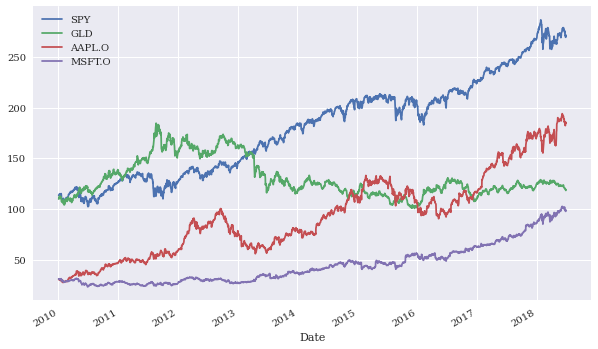

In [10]:
# Non normalized prices of financial instruments over time
data.plot(figsize=(10, 6));

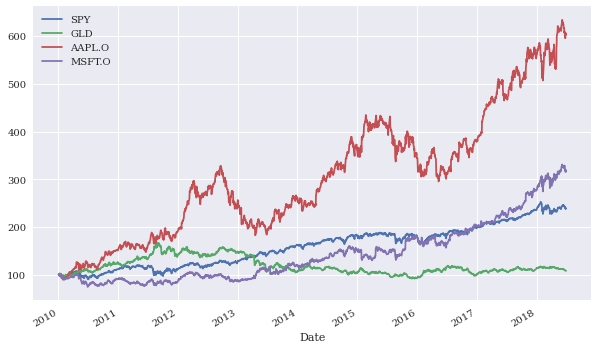

In [11]:
# Normalized prices of financial instruments over time
(data / data.iloc[0] * 100).plot(figsize=(10, 6));

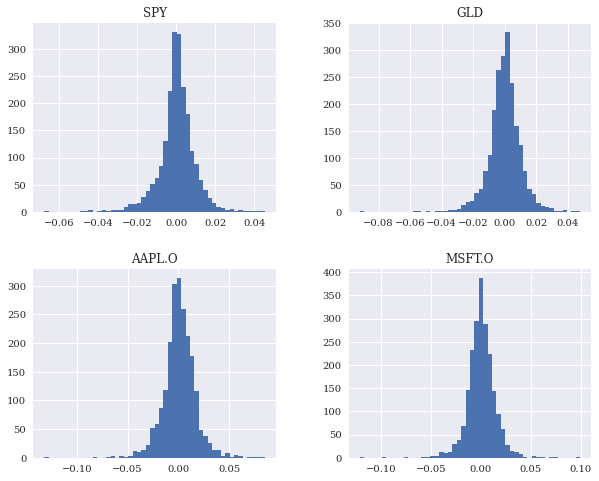

In [12]:
# Histograms of log returns for financial instruments
log_returns = np.log(data / data.shift())
log_returns.hist(bins=50, figsize=(10, 8));

In [13]:
# statistics for time series of financial instruments
#   the kurtosis values seem to be especially far from normal for all four data sets

for sym in symbols:
    print(f'\nResults for symbol {sym}')
    print(30 * '-')
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data)


Results for symbol SPY
------------------------------
     statistic           value
------------------------------
          size      2137.00000
           min        -0.06734
           max         0.04545
          mean         0.00041
           std         0.00933
          skew        -0.52189
      kurtosis         4.52432

Results for symbol GLD
------------------------------
     statistic           value
------------------------------
          size      2137.00000
           min        -0.09191
           max         0.04795
          mean         0.00004
           std         0.01020
          skew        -0.59934
      kurtosis         5.68423

Results for symbol AAPL.O
------------------------------
     statistic           value
------------------------------
          size      2137.00000
           min        -0.13187
           max         0.08502
          mean         0.00084
           std         0.01591
          skew        -0.23510
      kurtosis         4.7

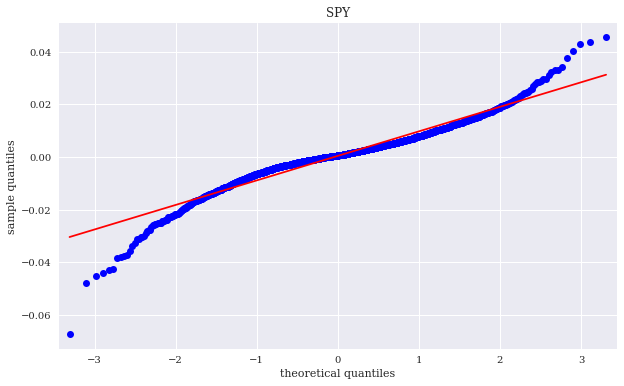

In [14]:
# QQ Plot for SPY log returns
sm.qqplot(log_returns['SPY'].dropna(), line='s')
plt.title('SPY');
plt.xlabel('theoretical quantiles');
plt.ylabel('sample quantiles');

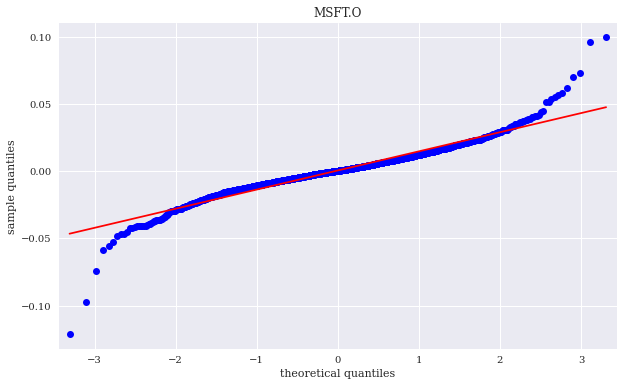

In [15]:
# QQ Plot for MSFT.O log returns
sm.qqplot(log_returns['MSFT.O'].dropna(), line='s')
plt.title('MSFT.O');
plt.xlabel('theoretical quantiles');
plt.ylabel('sample quantiles');

In [16]:
# Normality test results for the time series of the financial instruments
for sym in symbols:
    print(f'\nResults for symbol {sym}')
    print(32 * '-')
    log_data = np.array(log_returns[sym].dropna())
    normality_tests(log_data)


Results for symbol SPY
--------------------------------
Skew of data set          -0.522
Skew test p-value          0.000
Kurt of data set.          4.524
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol GLD
--------------------------------
Skew of data set          -0.599
Skew test p-value          0.000
Kurt of data set.          5.684
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol AAPL.O
--------------------------------
Skew of data set          -0.235
Skew test p-value          0.000
Kurt of data set.          4.790
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol MSFT.O
--------------------------------
Skew of data set          -0.091
Skew test p-value          0.085
Kurt of data set.          7.291
Kurt test p-value          0.000
Norm test p-value          0.000


---

# Simple Returns and Log Returns

__Normal Log Returns__<br>
Log returns $\text{log} \frac{S_t}{S_s} = \text{log} S_t - \text{log} S_s$ between two times $0 \lt s \lt t$ are normally distributed.<br>
__Log-Normal Values__<br>
At any time $t \gt 0$, the values $S_t$ are log-normally distributed.<br>

---

# Geometric Brownian Motion

$S$ geometric Brownian motion

105.12710963760242
105.12645392478755


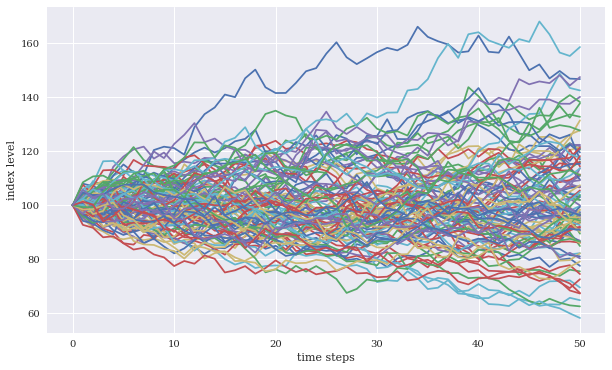

In [17]:
# Parameter values
S0    = 100.0             # initial stock/index value
r     = 0.05              # constant short rate
sigma = 0.2               # constant volatility
T     = 1.0               # time horizon in years fractions
M     = 50                # number of time intervals
I     = 250_000           # number of simulated processes

np.random.seed(1000)

paths = gen_paths(S0, r, sigma, T, M, I)

print(S0 * np.exp(r * T)) # expected value
print(paths[-1].mean())   # average simulated value

plt.figure(figsize=(10, 6));
plt.plot(paths[:, :100]);
plt.xlabel('time steps');
plt.ylabel('index level');

In [18]:
log_returns = np.log(paths[1:] / paths[:-1])
paths[:,0].round(4)       # a single simulated path
log_returns[:,0].round(4) # the resulting log returns

array([-0.022 ,  0.0075,  0.0743, -0.0024, -0.059 ,  0.0018,  0.0261,
        0.0289,  0.0136,  0.0156, -0.0051, -0.0171, -0.0516,  0.0095,
        0.0057,  0.0663, -0.0006,  0.0306,  0.0004, -0.0042,  0.0177,
       -0.0411,  0.0241,  0.0011,  0.0314, -0.0112, -0.0095,  0.0167,
        0.0128,  0.0047, -0.0645, -0.0053, -0.0463,  0.0288, -0.0214,
       -0.0059, -0.0079,  0.0386, -0.0266,  0.0305, -0.0049, -0.0123,
       -0.0094, -0.0153, -0.0324, -0.0269, -0.0127, -0.0178,  0.0104,
       -0.0009])

In [19]:
print_statistics(log_returns.flatten())

     statistic           value
------------------------------
          size  12500000.00000
           min        -0.15664
           max         0.15371
          mean         0.00060
           std         0.02828
          skew         0.00055
      kurtosis         0.00085


In [20]:
# annualized mean log return after correction for the Ito term
log_returns.mean() * M + 0.5 * sigma ** 2

0.05000000000000006

In [21]:
# annualized volatility (i.e., annualized standard deviation of log returns)
log_returns.std() * np.sqrt(M)

0.20000000000000015

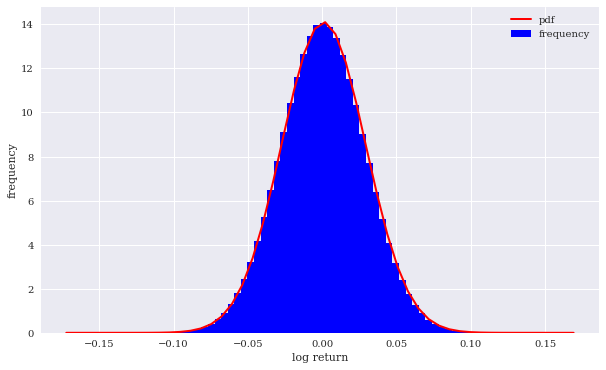

In [22]:
# graphical normality test: compare a frequency distribution (histogram) with a theoretical PDF

# Histogram of log returns of geometric Brownian motion and normal density function
#   compares the frequency distribution of the simulated log returns with the probability density function (PDF) of the normal distribution given the parameterizations for r and sigma
plt.figure(figsize=(10, 6));
plt.hist(log_returns.flatten(), bins=70, density=True, label='frequency', color='b');
plt.xlabel('log return');
plt.ylabel('frequency');
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=r/M, scale=sigma/np.sqrt(M)), 'r', lw=2.0, label='pdf'); # plots the PDF for the assumed parameters scaled to the interval length
plt.legend();

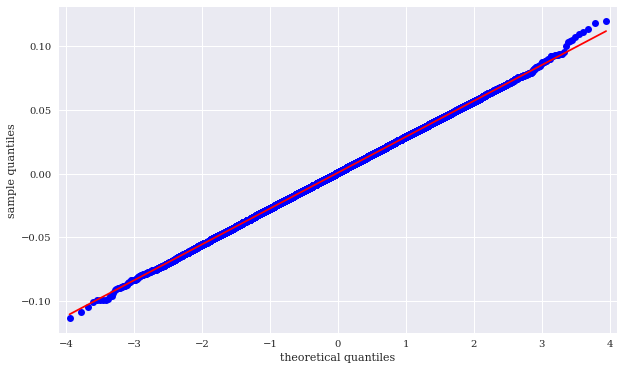

In [23]:
# graphical normality test
# QQ Quantile-Quantile Plot for log returns of geometric Brownian motion
#   sample quantile values are compared to theoretical quantile values
sm.qqplot(log_returns.flatten()[::500], line='s')
plt.xlabel('theoretical quantiles');
plt.ylabel('sample quantiles');

---

# More Robust Models that don't assume normality

models that can generate fat tails<br>
__Jump Diffusion Models__<br>
__Models with Stochastic Volatility__<br>

---

# BSM 

Example of the valuation of European call option by Monte Carlo simulation, in which the option's underlying risk factor follows a geometric Brownian motion<br>

Black-Scholes-Merton (1973) index level at maturity, a random variable given by<br>
$$S_T = S_0 \text{exp} ((r - \frac{1}{2}\sigma^2)T + \sigma\sqrt{T}z)$$<br>
$S_0$ initial stock index level<br>
$K$ European call option strike price<br>
$T$ time to maturity [years]<br>
$r$ constant, riskless short rate<br>
$\sigma$ constant volatility<br>
$z$ standard normally distributed random variable<br>

Monte Carlo estimator for European option<br>
$$C_0 \approx e^{-rT} \frac{1}{I} \sum_I h_T(i)$$<br>

Monte Carlo valuation algorithm:<br>
1. Draw $I$ pseudo-random numbers $z(i)$, $i \in {1, 2, ..., I}$, from the standard normal distribution.
2. Calculate all resulting index levels at maturity $S_T(i)$ for given $z(i)$ and BSM model.
3. Calculate all inner values of the option at maturity as $h_T(i) = \text{max}(S_T(i) - K, 0)$.
4. Estimate the option present value via the Monte Carlo estimator.

In [24]:
# Parameter values
S0    = 100.0        # initial stock index level
K     = 105.0        # European call option strike price
T     = 1.0          # time to maturity [years]
r     = 0.05         # constant, riskless short rate
sigma = 0.2          # constant volatility
I     = 100_000      # number of simulations

# Valuation Algorithm
np.random.seed(1000)
z  = np.random.standard_normal(I)                                   # standard normally distributed pseudo-random numbers are drawn
ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * z) # EOPeriod values (index values at maturity) are simulated
hT = np.maximum(ST - K, 0)                                          # option payoffs at maturity are calculated
C0 = np.exp(-r * T) * np.mean(hT)                                   # Monte Carlo estimator is evaluated

print(f'Value of the European call option: {C0:5.3f}.')

Value of the European call option: 8.019.


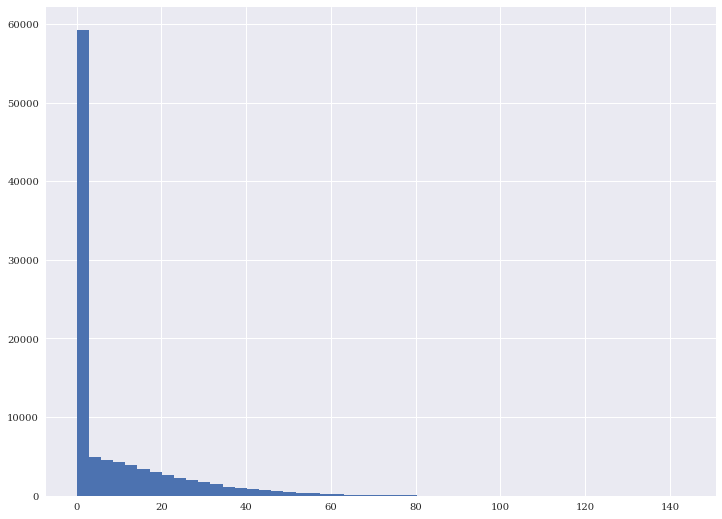

In [25]:
plt.figure(figsize=(12, 9));
plt.hist(hT, bins=50);

---

# Normality Testing

In [26]:
# the test values indicate that the log returns of the geometric Brownian motion are indeed normally distributed
# they show p-values of 0.05 or above
normality_tests(log_returns.flatten())

Skew of data set           0.001
Skew test p-value          0.430
Kurt of data set.          0.001
Kurt test p-value          0.541
Norm test p-value          0.607


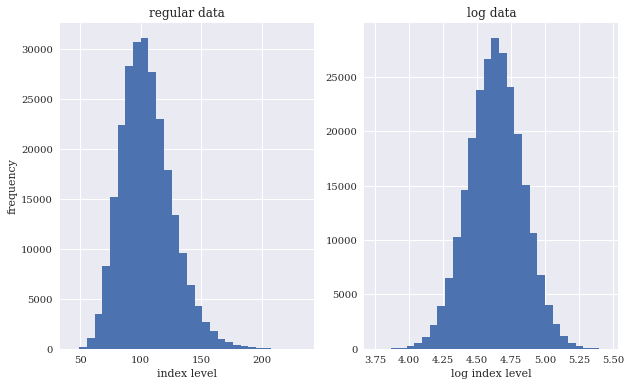

In [27]:
# the log-normally distributed end-of-period values and the transformed, normally distributed values
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6));
ax1.hist(paths[-1], bins=30);
ax1.set_xlabel('index level');
ax1.set_ylabel('frequency');
ax1.set_title('regular data');
ax2.hist(np.log(paths[-1]), bins=30);
ax2.set_xlabel('log index level');
ax2.set_title('log data');

In [28]:
print_statistics(paths[-1])

     statistic           value
------------------------------
          size    250000.00000
           min        42.74870
           max       233.58435
          mean       105.12645
           std        21.23174
          skew         0.61116
      kurtosis         0.65182


In [29]:
print_statistics(np.log(paths[-1]))

     statistic           value
------------------------------
          size    250000.00000
           min         3.75534
           max         5.45354
          mean         4.63517
           std         0.19998
          skew        -0.00092
      kurtosis        -0.00327


In [30]:
normality_tests(np.log(paths[-1]))

Skew of data set          -0.001
Skew test p-value          0.851
Kurt of data set.         -0.003
Kurt test p-value          0.744
Norm test p-value          0.931


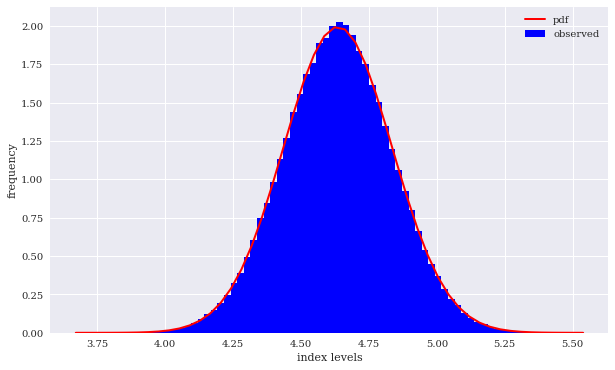

In [31]:
# Histogram of log index levels of geometric Brownian motion and normal density function

plt.figure(figsize=(10, 6));
log_data = np.log(paths[-1])
plt.hist(log_data, bins=70, density=True, label='observed', color='b');
plt.xlabel('index levels');
plt.ylabel('frequency');
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, log_data.mean(), log_data.std()), 'r', lw=2.0, label='pdf');
plt.legend();

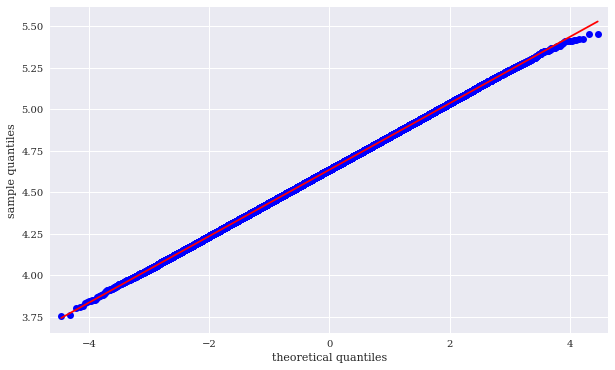

In [32]:
# QQ Plot for log index levels of geometric Brownian motion
sm.qqplot(log_data, line='s')
plt.xlabel('theoretical quantiles');
plt.ylabel('sample quantiles');

---

In [34]:
data.describe().round(2)

,SPY,GLD,AAPL.O,MSFT.O
count,2138.00,2138.00,2138.00,2138.00
mean,180.32,130.09,93.46,44.56
std,48.19,18.78,40.55,19.53
min,102.20,100.50,27.44,23.01
25%,133.99,117.40,60.29,28.57
50%,186.32,124.00,90.55,39.66
75%,210.99,139.00,117.24,54.37
max,286.58,184.59,193.98,102.49


In [35]:
data.aggregate([np.min, np.mean, np.std, np.median, np.max]).round(2)

,SPY,GLD,AAPL.O,MSFT.O
amin,102.20,100.50,27.44,23.01
mean,180.32,130.09,93.46,44.56
std,48.19,18.78,40.55,19.53
median,186.32,124.00,90.55,39.66
amax,286.58,184.59,193.98,102.49


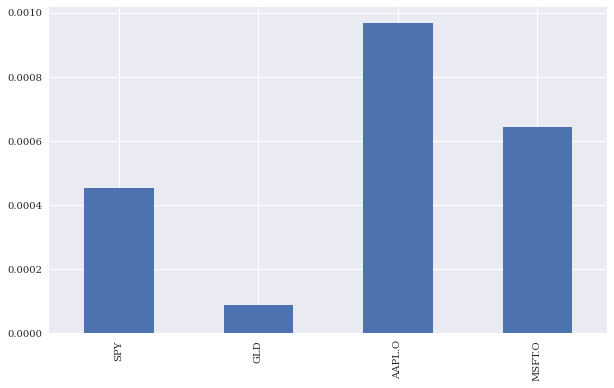

In [36]:
data.pct_change().mean().plot.bar(figsize=(10, 6));

In [37]:
rets = np.log(data / data.shift())
rets.round(3).head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,0.003,-0.001,0.002,0.000
2010-01-06,0.001,0.016,-0.016,-0.006
2010-01-07,0.004,-0.006,-0.002,-0.010
2010-01-08,0.003,0.005,0.007,0.007


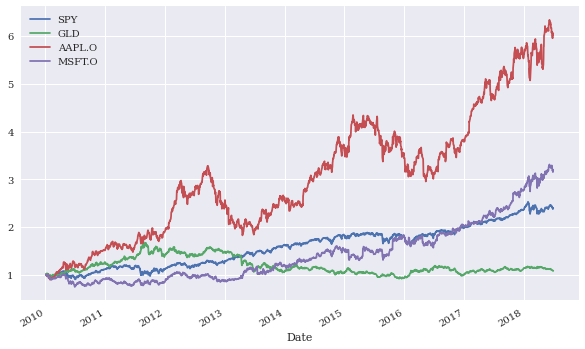

In [38]:
(data / data.shift()).cumprod().plot(figsize=(10, 6));

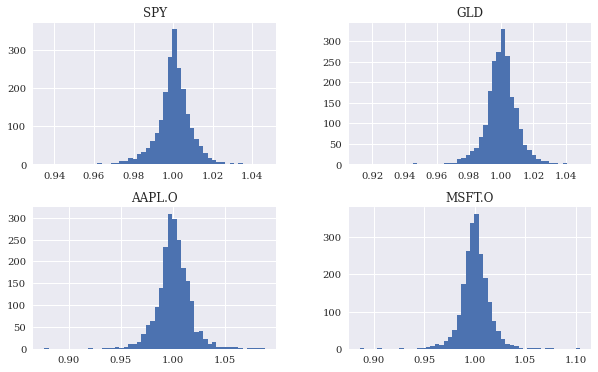

In [39]:
(data / data.shift()).hist(bins=50, figsize=(10, 6));

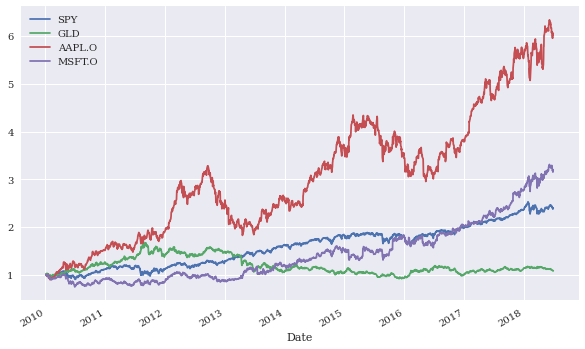

In [40]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6));

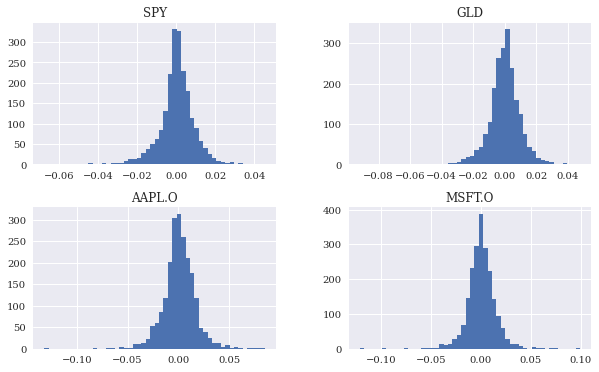

In [41]:
rets.hist(bins=50, figsize=(10, 6));

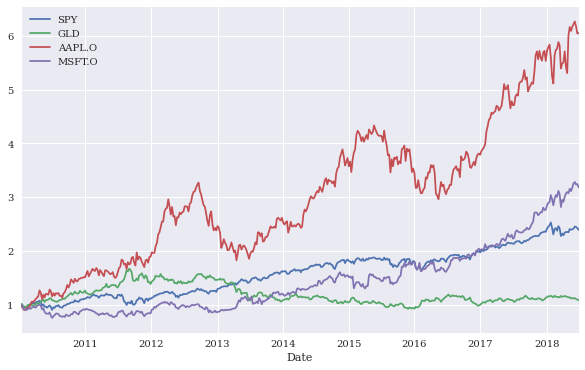

In [42]:
rets.cumsum().apply(np.exp).resample('1w', label='right').last().plot(figsize=(10, 6));

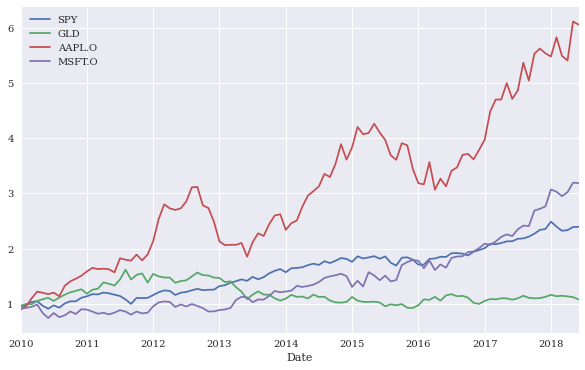

In [43]:
rets.cumsum().apply(np.exp).resample('1m', label='right').last().plot(figsize=(10, 6));

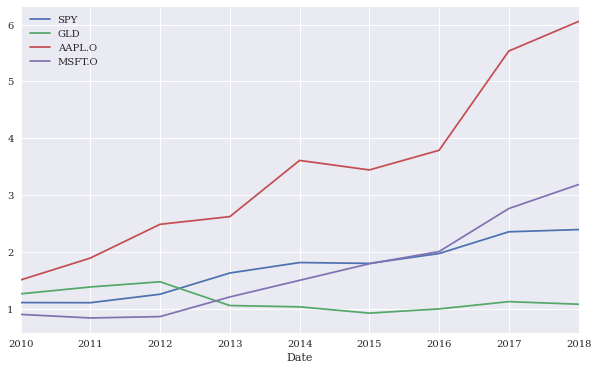

In [44]:
rets.cumsum().apply(np.exp).resample('1y', label='right').last().plot(figsize=(10, 6));

---

# MPT Modern (Mean-Variance) Portfolio Theory

"By looking only at mean and variance, we are necessarily assuming that no other statistics are necessary to describe the distribution of end-of-period wealth. Unless investors have a special type of utility function (quadratic utility function), it is necessary to assume that returns have a normal distribution, which can be completely described by mean and variance." (Copeland, Weston, & Shastri 2005, Ch. 5)<br>

"The basic idea of MPT is to make use of _diversification_ to achieve a minimal portfolio risk given a target return level or a maximum portfolio return given a certain level of risk. One would expect such diversification effects for the right combination of a larger number of assets and a certain diversity in the assets." (Python for Finance)<br>

"Of paramount interest to investors is what risk-return profiles are possible for a given set of financial instruments, and their statistical characteristics." (Python for Finance)<br>

"As an investor, one is generally interested in the maximum return given a fixed risk level or the minimum risk given a fixed return expectation."<br>

__General formula for Expected Portfolio Return__
$$
\begin{align}
\mu_p &= \text{E} \left( \sum_I w_i r_i \right) \\
&= \sum_I w_i \text{E} (r_i) \\
&= \sum_I w_i \mu_i \\
&= w^T \mu \\
\end{align}
$$

such that $\sum_I w_i = 1$<br>
$I$ the number of financial instruments<br>
$w_i \gt 0$ the weight of financial instrument $i$<br>

__Covariance between two securities__<br>
$\sigma_{ij} = \sigma_{ji} = \text{E} (r_i - \mu_i)(r_j - \mu_j)$<br>
__Variance of a security__ is the special case of the covariance with itself<br>
$\sigma_i^2 = \text{E} ((r_i - \mu_i)^2)$<br>

__Covariance Matrix__ for a portfolio of securities (assuming an equal weight of 1 for every security)<br>
$
\Sigma =
\begin{bmatrix}
\sigma_1^2 & \sigma_{12} & ... & \sigma_{1I} \\
\sigma_{21} & \sigma_2^2 & ... & \sigma_{2I} \\
... & ... & ... & ... \\
\sigma_{I1} & \sigma_{I2} & ... & \sigma_I^2 \\
\end{bmatrix}
$

__General formula for Expected Portfolio Variance__<br>
$$
\begin{align}
\sigma_p^2 &= \text{E} ((r - \mu)^2) \\
&= \sum_{i \in I} \sum_{j \in I} w_i w_j \sigma_{ij} \\
&= s^T \Sigma w \\
\end{align}
$$

__Expected Portfolio Standard Deviation (Volatility)__<br>
$$\sigma_p = \sqrt{\sigma_p^2}$$

__Sharpe Ratio__<br>
the expected excess return of the porfolio over the risk-free short rate $r_f$ divided by the expected standard deviation of the portfolio<br>
for simplicity, assume $r_f \equiv 0$<br>
$$SR \equiv \frac{\mu_p - r_f}{\sigma_p}$$

__Efficient Frontier__<br>
comprised of all optimal portfolios with a higher return than the absolute minimum variance portfolio<br>
these portfolios dominate all other portfolios in terms of expected returns given a certain risk level<br>

__Capital Market Line__<br>
derive a linear function $t(x) = a + b \cdot x$ representing the line that passes through the riskless asset in risk-return space and that is tangent to the efficient frontier<br>
__mathematical conditions for Capital Market Line__<br>
$$
\begin{alignat}{3}
t(x) &= a + b \cdot x \\
t(0) &= r_f &&\iff a &&= r_f \\
t(x) &= f(x) &&\iff a + b \cdot x &&= f(x) \\
t'(x) &= f'(x) &&\iff b &&= f'(x) \\
\end{alignat}
$$

---

In [45]:
def port_ret (weights):
    return np.sum(rets.mean() * weights) * 252
def port_vol (weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
def min_func_sharpe (weights):
    return -port_ret(weights) / port_vol(weights)
def f (x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df (x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)
def equations (p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

---

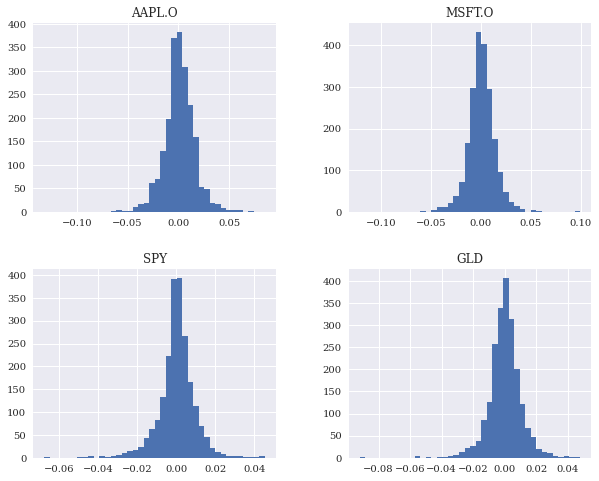

In [46]:
data = pd.read_csv('temp_data/tr_eikon_eod_data.csv', index_col=0, parse_dates=True, infer_datetime_format=True).dropna()
symbols = ['AAPL.O', 'MSFT.O', 'SPY', 'GLD']
noa = 4
data = data[symbols]
rets = np.log(data / data.shift())
# Histograms of log returns of financial instruments
rets.hist(bins=40, figsize=(10, 8));

In [47]:
# Annualized Mean Returns
rets.mean() * 252

AAPL.O    0.212359
MSFT.O    0.136648
SPY       0.102928
GLD       0.009141
dtype: float64

In [48]:
# Annualized Covariance Matrix
rets.cov() * 252

,AAPL.O,MSFT.O,SPY,GLD
AAPL.O,0.063773,0.023427,0.021039,0.001513
MSFT.O,0.023427,0.050917,0.022244,-0.000347
SPY,0.021039,0.022244,0.021939,0.000062
GLD,0.001513,-0.000347,0.000062,0.026209


"It is assumed that an investor is not allowed to set up short positions in a financial instrument. Only long positions are allowed, which implies that 100% of the investor's wealth has to be divided among the available instruments in such a way that all positions are long (positive) and that the positions add up to 100%."<br>

"Given the four instruments, one could, for example, invest equal amounts into every such instrument--i.e., 25% of the available wealth in each."

In [49]:
# generate four uniformly distributed random numbers between 0 and 1 and then normalize the values such that the sum of all values equals 1
weights = np.random.random(noa) # random portfolio weights...
weights /= np.sum(weights)      # ...normalized to 1 or 100%
print(weights)
print(weights.sum())

[0.42677902 0.17317355 0.15375873 0.24628869]
1.0000000000000002


In [50]:
# Annualized Portfolio Returns given the portfolio weights
np.sum(rets.mean() * weights) * 252

0.1323717231942442

In [51]:
# Annualized (Expected) Portfolio Variance, given portfolio weights
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.02295269702012512

In [52]:
# Annualized (Expected) Portfolio Volatility, given portfolio weights
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.15150147530676103

---

In [53]:
# generate random portfolio weight vectors
# for every simulated allocation, the code records the resulting expected portfolio return and variance



prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

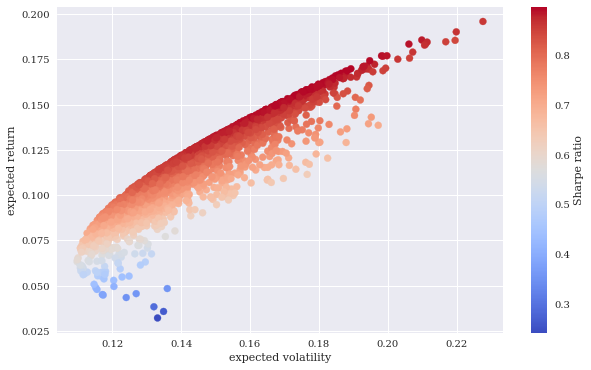

In [54]:
# Expected Return and Expected Volatility for random portfolio weights
plt.figure(figsize=(10, 6));
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm');
plt.xlabel('expected volatility');
plt.ylabel('expected return');
plt.colorbar(label='Sharpe ratio');

---

### Portfolio Optimization

#### 1. Maximization of the Sharpe Ratio
the negative value of the Sharpe ratio is minimized to derive the maximum value and the optimal portfolio composition<br>
the constraint is that all parameters (weights) sum to 1<br>
the parameter (weight) values are bound between 0 and 1<br>

In [55]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # equality constraint
bnds = tuple((0, 1) for x in range(noa))                # bounds for the parameters
eweights = np.array(noa * [1.0 / noa])                  # equal weights vector
print(eweights)
print(min_func_sharpe(eweights))

[0.25 0.25 0.25 0.25]
-0.84362033631554


In [56]:
# optimization and optimization results

In [57]:
%%time
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
opts

CPU times: user 37 ms, sys: 1.73 ms, total: 38.7 ms
Wall time: 37.2 ms


     fun: -0.8976673894018704
     jac: array([ 0.00008969,  0.00008304, -0.00024597,  0.0000193 ])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.51191355, 0.19126413, 0.25454107, 0.04228125])

In [58]:
# optimal portfolio weights
opts['x'].round(3)

array([0.512, 0.191, 0.255, 0.042])

In [59]:
# resulting portfolio return
port_ret(opts['x']).round(3)

0.161

In [60]:
# resulting portfolio volatility
port_vol(opts['x']).round(3)

0.18

In [61]:
# maximum Sharpe ratio
port_ret(opts['x']) / port_vol(opts['x'])

0.8976673894018704

#### 2. Minimization of the Variance (Volatility) of the portfolio
this time, the portfolio is made up of only three financial instruments<br>
this portfolio mix leads to the so-called _minimum volatility_ or _minimum variance portfolio_<br>

In [62]:
# optimization: minimization of portfolio volatility
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     fun: 0.1094215526340871
     jac: array([0.11098003, 0.10948556, 0.10939826, 0.10944918])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.        , 0.00106171, 0.54326308, 0.45567521])

In [63]:
optv['x'].round(3)

array([0.   , 0.001, 0.543, 0.456])

In [64]:
port_vol(optv['x']).round(3)

0.109

In [65]:
port_ret(optv['x']).round(3)

0.06

In [66]:
port_ret(optv['x']) / port_vol(optv['x'])

0.5504173646340133

---

In [67]:
# Efficient Frontier
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, # two binding constraints for the efficient frontier
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [68]:
%%time
trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons) # the minimization of portfolio volatility for different target returns
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 2.19 s, sys: 8.12 ms, total: 2.19 s
Wall time: 2.19 s


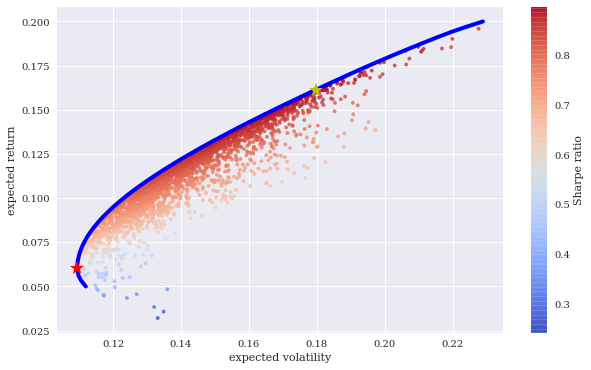

In [69]:
plt.figure(figsize=(10, 6));
plt.scatter(pvols, prets, c=prets/pvols, marker='.', alpha=0.8, cmap='coolwarm');
plt.plot(tvols, trets, 'b', lw=4.0);
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0);
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0);
plt.xlabel('expected volatility');
plt.ylabel('expected return');
plt.colorbar(label='Sharpe ratio');

---

In [70]:
# Capital Market Line

ind = np.argmin(tvols)         # index position of minimum volatility portfolio
evols = tvols[ind:]            # relevant portfolio volatility values
erets = trets[ind:]            # relevant portfolio return values
tck = sci.splrep(evols, erets) # cubic spline interpolation on these values

opt = sco.fsolve(equations, [0.01, 0.5, 0.15]) # solving these equations for given initial values
print(opt)                                     # the optimal parameter values
print(np.round(equations(opt), 6))             # the equation values are all zero

[0.01       0.84470952 0.19525392]
[ 0.  0. -0.]


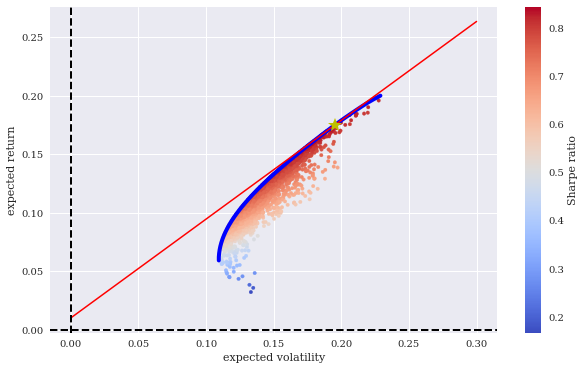

In [71]:
# Capital Market Line and Tangent Portfolio (star) for risk-free rate of 1%
plt.figure(figsize=(10, 6));
plt.scatter(pvols, prets, c=(prets-0.01)/pvols, marker='.', cmap='coolwarm');
plt.plot(evols, erets, 'b', lw=4.0);
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5);
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0);
plt.grid(True);
plt.axhline(0, color='k', ls='--', lw=2.0);
plt.axvline(0, color='k', ls='--', lw=2.0);
plt.xlabel('expected volatility');
plt.ylabel('expected return');
plt.colorbar(label='Sharpe ratio');

In [72]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - f(opt[2])}, # binding constraints for the tangent portfolio (star)
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
print(res['x'].round(3)) # the portfolio weights for this particular portfolio
print(port_ret(res['x']))
print(port_vol(res['x']))
print(port_ret(res['x']) / port_vol(res['x']))

[0.59  0.221 0.189 0.   ]
0.17493284326796382
0.1952537200423139
0.8959257894295367


---

# ARIMA Autoregressive Integrated Moving Average

In [ ]:
data = pdr.get_data_fred('HOUSTNSA', '1959-01-01', '2019-06-01')
housing = data.HOUSTNSA.pct_change().dropna()
housing = 100 * housing.asfreq('MS')
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

In [ ]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
res.summary()

In [ ]:
res = mod.fit(cov_type='HC0')
res.summary()

In [ ]:
sel = ar_select_order(housing, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
res.summary()

In [ ]:
fig = res.plot_predict(720, 840)

In [ ]:
fig = res.plot_diagnostics(lags=30)

---